# Intro to JAX: Inferring noisy 2D Gaussian parameters with gradient descent, HMC and SBI/ILI
### by Viraj Pandya (vgp2108@columbia.edu) 
### for May 28, 2025 SBI for Galaxy Evolution Conference at the University of Bristol

This notebook provides a general introduction to JAX using a "simple" inference problem to focus our attention and demonstrate some key practical features of JAX.

Imagine we want to infer the parameters of a 2D Gaussian from data. The data could come in many forms (realistically: a collection of discrete noisy points giving x-y pairs) but for this first simple example, let's assume we "observe" a noisy 2D image of the Gaussian (which could be a galaxy!). From this image alone, we want to infer the parameters of the 2D Gaussian that gave rise to it -- there are 5 such parameters: 

- means [$\mu_x$, \$\mu_y$]
   
- standard deviations [$\sigma_x$, $\sigma_y$]

- correlation coefficient $\rho_{xy}$

The latter three parameters define the covariance matrix of a 2D Gaussian (which tells us its orientation, ellipticity, etc.): 

$$
\begin{bmatrix}
\sigma_x^2 & \rho_{xy}\sigma_x\sigma_y \\
\rho_{xy}\sigma_x\sigma_y & \sigma_y^2
\end{bmatrix}
$$

In this self-contained tutorial, we'll use JAX to create noisy 2D Gaussian images and infer true parameters using gradient descent, HMC and SBI/ILI.

#### Note: on colab, this should run on both CPU and GPU runtime types

In [1]:
%matplotlib inline

# For GPU, disable cores/devices above, and don't pre-allocate jax memory (usually too small)
# import os
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# jax assumes float32 by default -- need to explicitly enable float64 (generally a good idea)
from jax import config
config.update("jax_enable_x64", True) 

# if we're running on CPU, need to pre-specify # cores for explicit parallelism 
# used to have to do import os; os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8" 
config.update('jax_num_cpu_devices', 8) 

import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from jax.random import PRNGKey as key
from jax.scipy.stats import multivariate_normal as jax_mvnormal
from jax.sharding import PartitionSpec 

from timeit import default_timer as timer
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, AIES

# by default when running on CPU, jax will only detect one CPU core, unless you set the XLA_FLAG above (useful for shard_map)
print(jax.__version__)
print(jax.devices())
print(jax.local_device_count())

0.6.1
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]
8


# JAX is a drop-in replacement for (much of) numpy and scipy

But there are a lot of "gotcha's" if you want to use JAX optimally -- we'll only cover the high-level stuff here. Some other good tutorials:

- https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html
- https://jax.quantecon.org/intro.html
- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html

In [2]:
# note how the jax version explicitly keeps tracks of the dtype of the array entries.
np_arr = np.linspace(0,1,5)
jnp_arr = jnp.linspace(0,1,5)

np_arr, jnp_arr

(array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 Array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float64))

In [3]:
# unlike numpy arrays, jax arrays are immutable -- cannot be modified in-place
jnp_arr[0] = 99

TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [4]:
# if you really wanted to, you could instead return a modified copy of the array like this
jnp_arr2 = jnp_arr.at[0].set(99)

# but note that the original array was NOT modified in place
jnp_arr, jnp_arr2

(Array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float64),
 Array([99.  ,  0.25,  0.5 ,  0.75,  1.  ], dtype=float64))

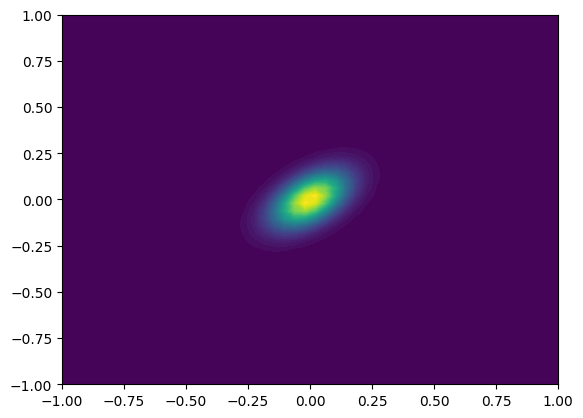

In [5]:
""" the following uses standard jax versions of standard numpy/scipy functions """

# first choose some example true parameters
true_params = jnp.array([0.0,0.0,0.1,0.1,0.5])

### let's evaluate the logpdf of a multivariate (2D) normal with known mean and cov matrix over some grid 
# first set mean (x,y) of 2D gaussian
mu_true = jnp.array([true_params[0],true_params[1]])
cov_true = jnp.array([[true_params[2]**2,true_params[4]*true_params[2]*true_params[3]], 
                      [true_params[4]*true_params[2]*true_params[3],true_params[3]**2]])

# choose a 2D (x,y) meshgrid that encompasses true distribution
x_grid, y_grid = jnp.linspace(-1,1,50), jnp.linspace(-1,1,50)
x_meshgrid, y_meshgrid = jnp.meshgrid(x_grid,y_grid)
xy_points = jnp.stack([x_meshgrid.ravel(), y_meshgrid.ravel()], axis=-1) # stacked into (N, 2) array of points as required for logpdf function next

# use jax.scipy.stats.multivariate_normal.logpdf to evaluate 2D Gaussian over our xy grid
logpdf_grid = jax_mvnormal.logpdf(xy_points, mean=mu_true, cov=cov_true).reshape(x_meshgrid.shape)

### plot
plt.contourf(x_grid, y_grid, jnp.exp(logpdf_grid), levels=50)



# Pseudorandom numbers in JAX

Unlike numpy which uses a state-based RNG, jax.random functions all require the first argument to be a jax RNG key. This helps reproducibility so it's good practice anyway. Recall that normally we'd do something like numpy.random.seed(#) -- here similarly we can do jax.random.key(1) 

See https://docs.jax.dev/en/latest/random-numbers.html

In [6]:
# similar to how in numpy, we'd do something like np.random.seed(1), we can use jax.random.key with some input seed
base_key = key(seed=1) # jax.random.key
base_key

Array([0, 1], dtype=uint32)

In [7]:
### what if we needed many RNG keys downstream in a function (dependent on some original RNG key)? 

# each one is a "subkey" that could be used to generate other random numbers (again, reproducible)
subkeys = jax.random.split(base_key,2) 
subkeys

Array([[ 507451445, 1853169794],
       [1948878966, 4237131848]], dtype=uint32)

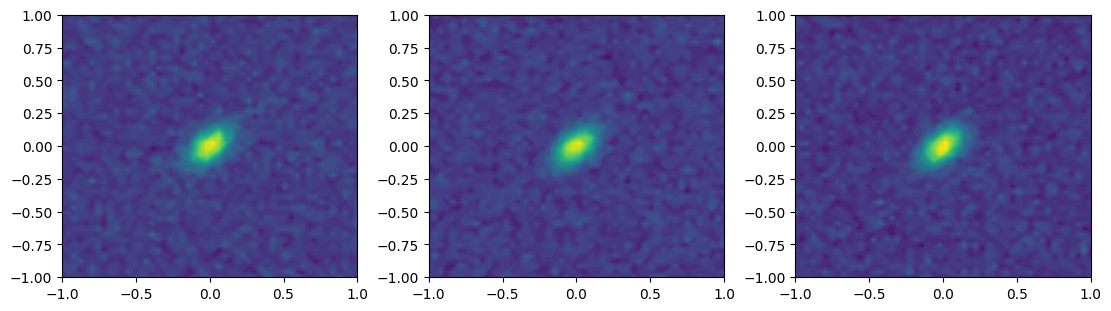

In [8]:
### now let's use our 3 keys to sample 3 different 2D gaussian noise images to add to our true image


noisy_obs0 = jnp.exp(logpdf_grid) + jax.random.normal(base_key,shape=logpdf_grid.shape) 
noisy_obs1 = jnp.exp(logpdf_grid) + jax.random.normal(subkeys[0],shape=logpdf_grid.shape) 
noisy_obs2 = jnp.exp(logpdf_grid) + jax.random.normal(subkeys[1],shape=logpdf_grid.shape) 

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(11,3),constrained_layout=True)

axes[0].contourf(x_grid, y_grid, noisy_obs0, levels=50)
axes[1].contourf(x_grid, y_grid, noisy_obs1, levels=50)
axes[2].contourf(x_grid, y_grid, noisy_obs2, levels=50)

# Just-in-time compilation

Python is an interpreted language so it is slow -- JAX offers a ~10x speed-up on CPU and enables running the same code on other accelerators (GPUs, TPUs) with just-in-time (JIT) compilation. This involves using the @jax.jit decorator. The first time you run a function it gets compiled down to machine-level instructions using the OpenXLA library -- this jitted function gets "cached" so subsequent calls are much faster. But this requires being careful with inputs (which are traced and whose shapes must be known at runtime and remain static), control flow (if/else), etc. Functional programming is encouraged.

Let's convert the above code into a jitted simulator function.

True


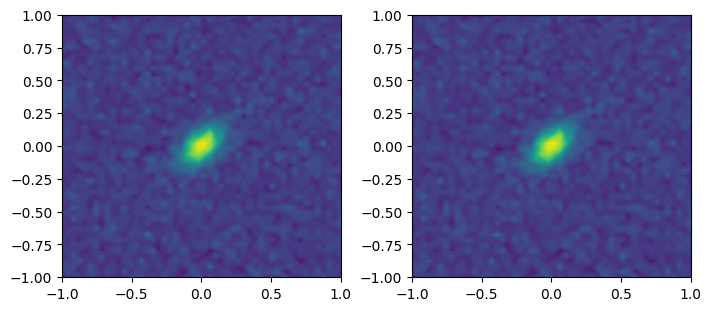

In [79]:
### define simulator -- this is the same as above but now packaged into a jitted function

# @jax.jit
def simulator(params, rng_key):
    # params order = jnp.array([mu_x, mu_y, sigma_x, sigma_y, rho_xy]) 

    # first package into mu vector and cov matrix 
    mu = params[:2]
    cov = jnp.array([[params[2]**2,params[4]*params[2]*params[3]], 
                      [params[4]*params[2]*params[3],params[3]**2]])

    # evaluate logpdf
    logpdf_grid = jax_mvnormal.logpdf(xy_points, mean=mu, cov=cov).reshape(x_meshgrid.shape)
    
    # add noise
    noise = jax.random.normal(rng_key,shape=logpdf_grid.shape) # can multiply this by scalar to make it noisier
    noisy_obs = jnp.exp(logpdf_grid)+noise    
    
    # Simulate n samples from N(mu, 1)
    return noisy_obs


### test it by running with the same base_key above (reproducibility!)

noisy_obs = simulator(true_params,base_key) 
print(jnp.allclose(noisy_obs,noisy_obs0)) 

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(7,3),constrained_layout=True)
axes[0].contourf(x_grid, y_grid, noisy_obs0, levels=50)
axes[1].contourf(x_grid, y_grid, noisy_obs, levels=50)



In [80]:
%timeit simulator(true_params,base_key)

2.05 ms ± 19.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
jit_simulator = jax.jit(simulator)

# the first time takes longer since it's jit-compiling down to XLA
%time _ = jit_simulator(true_params,base_key)

# subsequent runs should be faster than non-jitted version
%time _ = jit_simulator(true_params,base_key)

CPU times: user 225 ms, sys: 34.8 ms, total: 260 ms
Wall time: 133 ms
CPU times: user 31 μs, sys: 9 μs, total: 40 μs
Wall time: 42 μs


In [112]:
### what is jit actually doing? it is converting your function into a computational graph -- a sequence of low-level math operations
jax.make_jaxpr(jit_simulator)(true_params,base_key)

{ lambda ; a:f64[5] b:u32[2]. let
    c:f64[50,50] = pjit[
      name=simulator
      jaxpr={ lambda d:f64[2500,2]; a:f64[5] b:u32[2]. let
          e:f64[2] = slice[limit_indices=(2,) start_indices=(0,) strides=None] a
          f:f64[1] = slice[limit_indices=(3,) start_indices=(2,) strides=None] a
          g:f64[] = squeeze[dimensions=(0,)] f
          h:f64[] = integer_pow[y=2] g
          i:f64[1] = slice[limit_indices=(5,) start_indices=(4,) strides=None] a
          j:f64[] = squeeze[dimensions=(0,)] i
          k:f64[1] = slice[limit_indices=(3,) start_indices=(2,) strides=None] a
          l:f64[] = squeeze[dimensions=(0,)] k
          m:f64[] = mul j l
          n:f64[1] = slice[limit_indices=(4,) start_indices=(3,) strides=None] a
          o:f64[] = squeeze[dimensions=(0,)] n
          p:f64[] = mul m o
          q:f64[1] = slice[limit_indices=(5,) start_indices=(4,) strides=None] a
          r:f64[] = squeeze[dimensions=(0,)] q
          s:f64[1] = slice[limit_indices=(3,)

# Automatic vectorization

JAX makes it easy to run a function over many different batched array inputs using automatic vectorization and parallelization. This is a complicated topic -- see https://docs.jax.dev/en/latest/automatic-vectorization.html and https://docs.jax.dev/en/latest/sharded-computation.html 

Here we'll just use it to generate our training set and do SBI/ILI.

In [12]:
### let's draw many possible parameter sets from uniform priors 

llims = jnp.array([-1.0,-1.0,0.0,0.0,-1.0])
ulims = jnp.array([1.0,1.0,0.3,0.3,1.0])

@partial(jax.jit,static_argnums=1) # arrays must be static at runtime so cannot jit (or autodiff) wrt shape-related inputs (here: # prior samples)
def sample_prior(rng_key, n):
    return jax.random.uniform(rng_key, (n,5), minval=llims, maxval=ulims)

# test calling it for n prior samples
test_prior = sample_prior(key(1),10)
test_prior, test_prior.shape

(Array([[-0.76369951, -0.09248251,  0.17056577,  0.24923817, -0.59512941],
        [ 0.51031201,  0.06014349,  0.06668298,  0.14394121, -0.82377634],
        [-0.67582632, -0.73722141,  0.2048123 ,  0.21705665,  0.79990832],
        [-0.48183633,  0.54652306,  0.09441141,  0.27396647,  0.13001519],
        [-0.79085186, -0.8636397 ,  0.25893362,  0.20189987,  0.97814259],
        [-0.55533459,  0.82327392,  0.10949777,  0.19297118,  0.08678165],
        [ 0.02814074,  0.57082032,  0.21229968,  0.00529833,  0.99565931],
        [ 0.71289134, -0.24818475,  0.0652096 ,  0.16789356,  0.99013064],
        [-0.44185924, -0.89873127,  0.08724131,  0.26624335, -0.01388171],
        [ 0.15139212,  0.98062003,  0.1056153 ,  0.16551372, -0.41174419]],      dtype=float64),
 (10, 5))

In [13]:
# we also need 3 rng keys to map to each prior sample (this is used to generate different noise for each image)
test_keys = jax.random.split(key(60),len(test_prior))
test_keys

Array([[2160965587, 3379472782],
       [1125750657, 2567341973],
       [3130777049,  309609104],
       [3429055531,  867806927],
       [3624487439, 1415355448],
       [2140121368, 1204915162],
       [2818989714, 3581388384],
       [1117266750,  231402717],
       [ 416915936, 1404964369],
       [2461588643, 2515941441]], dtype=uint32)

(10, 50, 50)


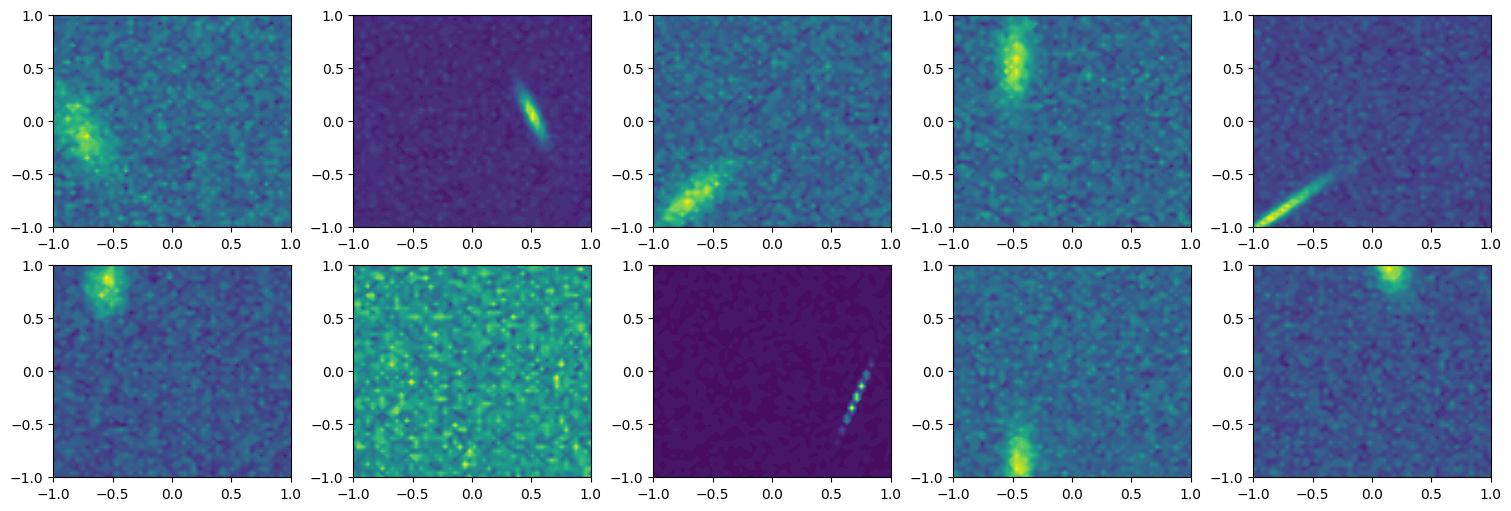

In [14]:
### create a vmapped version of simulator() to simultaneously evaluate noisy_obs for each test_prior+test_key combo

vmap_simulator = jax.jit(jax.vmap(simulator)) # note that I put jit outside

test_vmap_obs = vmap_simulator(test_prior,test_keys)
print(test_vmap_obs.shape) # so we have 3 noisy_obs corresponding to each combo of test_prior+test_key

fig, axes = plt.subplots(nrows=2,ncols=5,figsize=(15,5),constrained_layout=True)
allax = np.ravel(axes)

for i in range(10):
    allax[i].contourf(x_grid, y_grid, test_vmap_obs[i], levels=50)

# Automatic parallelization

### On colab, can only do this with CPU runtime (or if you have multiple GPUs)

JAX has an elegant straightforward way to parallelize a function to operate over multiple devices -- e.g., multiple CPU cores of a single CPU node or across multiple GPUs. JAX uses something called shard_map to implicitly split input batched data into different "shards" each of which has an integer multiple of the # of devices worth of data to process. Note that shard_map generally needs to be combined with an inner nested vmap (possibly multiple vmaps!) so that each device still vectorizes the computation over its available cores (most clear for GPUs).

This is a deeply rich but complicated topic -- see more here:
- https://docs.jax.dev/en/latest/sharded-computation.html#automatic-parallelism-via-jit 
- https://docs.jax.dev/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html

NOTE: in the remainder of this ipynb we'll just use vmap_simulator but you could try replacing it with shardmap_simulator instead!

In [50]:
# the input batch dimension must be divisible by the device count (whether that's # of CPU cores or # GPUs)
Nguess = 10000 * jax.local_device_count() # this says each device will be assigned a shard of the total dataset of size 1000 each (8000 total for 8 CPU cores)
sharded_prior = sample_prior(key(1),Nguess) 
sharded_keys = jax.random.split(key(100),Nguess)

sharded_prior.shape, sharded_keys.shape

((80000, 5), (80000, 2))

In [51]:
# make a device mesh 
device_mesh = jax.make_mesh((jax.local_device_count(),), axis_names=('x',))

# create a new JITTED function that applies shard_map to the (already-inner-nested-vmapped) vmap_simulator function
shardmap_simulator = jax.jit(jax.shard_map(vmap_simulator,mesh=device_mesh,in_specs=(PartitionSpec('x')),out_specs=PartitionSpec('x')))

# just run! 
test_shardmap = shardmap_simulator(sharded_prior, sharded_keys)

# note how shard_map already collected our outputs and returned a jax array of shape (Nguess, 50x50 images)
test_shardmap.shape

(80000, 50, 50)

In [52]:
### let's time it -- as you might expect, parallelized version is much faster as the # of inputs goes up

%time _ = vmap_simulator(sharded_prior,sharded_keys)

%time _ = shardmap_simulator(sharded_prior,sharded_keys)

CPU times: user 2.78 s, sys: 6.91 s, total: 9.69 s
Wall time: 2.05 s
CPU times: user 26 ms, sys: 183 ms, total: 209 ms
Wall time: 78.1 ms


In [108]:
# For colab: double checking where data is -- is it in fact on GPU?
sharded_prior.device

CpuDevice(id=0)

# Automatic differentiation

One of the most powerful aspects of JAX (like theano, pytorch, tensorflow, etc. before it) is that it allows you take the gradients of function outputs wrt inputs. These are exact gradients through the internals of the function -- not finite-differencing (which is numerical error prone) and not symbolic / by hand (which is only possible for the simplest functions). 



In [65]:
### let's start by defining an explicit gaussian likelihood

@jax.jit
def loss(params,noisy_obs,sigma=1.0):
    # params order = jnp.array([mu_x, mu_y, sigma_x, sigma_y, rho_xy]) 
    # obs is the true noisy 2D gaussian image we're trying to fit

    # first package into mu vector and cov matrix 
    mu = params[:2]
    cov = jnp.array([[params[2]**2,params[4]*params[2]*params[3]], 
                      [params[4]*params[2]*params[3],params[3]**2]])

    # loss = negative gaussian log-likelihood: for simplicity assume all 2D pixels are independent, so can just sum their residuals
    pred_logpdf = jax_mvnormal.logpdf(xy_points, mean=mu, cov=cov).reshape(x_meshgrid.shape)
    residuals_2d = jnp.exp(pred_logpdf) - noisy_obs # note we defined noisy_obs as exp(logpdf)
    
    return -jnp.sum(-0.5*((residuals_2d/sigma)**2)) # or equivalently -jax_mvnormal.logpdf(residuals_2d, mean=0.0, cov=1.0).sum()


# confirm that true loss is better than loss of random prior draws
loss(true_params,noisy_obs),[loss(test_prior[i],noisy_obs) for i in range(len(test_prior))]

(Array(1228.9620928, dtype=float64),
 [Array(4735.95763746, dtype=float64),
  Array(8350.01674924, dtype=float64),
  Array(4877.62046369, dtype=float64),
  Array(4956.38914596, dtype=float64),
  Array(5957.23946341, dtype=float64),
  Array(5066.19061014, dtype=float64),
  Array(4034.14392739, dtype=float64),
  Array(19454.58189395, dtype=float64),
  Array(4774.094885, dtype=float64),
  Array(5007.0595257, dtype=float64)])

In [69]:
### now compute gradient of loss wrt the 5 parameters -- by default grad only operates on first arg, so we're safe
grad_loss = jax.grad(loss)

# grad should be close to ~0 at true minimum except we have noise
print('=====> true gradnorm and grad_loss')
grad_loss_true = grad_loss(true_params,noisy_obs)
print(jnp.linalg.norm(grad_loss_true), grad_loss_true)

# the gradnorm of the other random prior draws are much larger -- good since 
print('=====> gradnorm and grad loss at random prior draws') 
for i in range(len(test_prior)):
    grad_loss_i = grad_loss(test_prior[i],noisy_obs)
    print(jnp.linalg.norm(grad_loss_i),grad_loss_i)

=====> true gradnorm and grad_loss
703.7270217797893 [-554.16313102 -131.10977754  410.44562161   49.72331898   -2.67486215]
=====> gradnorm and grad loss at random prior draws
5406.344572134177 [  216.46454784    16.16433389 -4539.85195584 -2862.95548394
  -612.10584261]
72836.8023282798 [  1253.21080831    109.7139716  -64919.7968223  -31039.55481316
 -11206.39176881]
6860.836465432649 [  -37.18150162   139.52338241 -4609.98958683 -4739.45305984
  1826.41957665]
10469.96169118153 [ -205.43321198   -65.13388895 -9881.79057327 -3449.18083067
   164.37533285]
47469.20432468967 [  -209.57394646   3573.70507104  -8443.70103671 -11477.73425241
  45138.40492617]
11561.528748712244 [  413.78879106  -954.72596042 -9521.78691512 -6474.1508684
    84.66794201]
5514.690454831828 [ 4.34572884e+00 -2.13163425e+02 -3.89303403e+01  5.51018140e+03
  5.23318512e+01]
813087.2342059124 [ -26547.56883761   10797.43540101 -228818.44805264  -94323.36312829
  773973.32861355]
9082.903719624717 [  -32.684358

# Gradient descent with optax.adam

For simplicity, we'll assume uniform priors and will not penalize out of bounds parameters so we can minimize the negative gaussian log-L (=log-posterior) directly.

In [70]:
def run_adam(init_params,init_num,verbose=False):
    
    ### define an exponential decay learning rate schedule
    # this is currently what I use for sapphire (ODE inference), might be overkill / unnecessary for 
    initial_learning_rate = 1e-2   # Initial learning rate
    decay_rate = 0.95              # decay rate per step
    decay_steps = 50             # number of steps before applying decay
    min_learning_rate = 1e-4      # min learning rate to clip at
    
    lr_schedule = optax.exponential_decay(init_value=initial_learning_rate,
                                          transition_steps=decay_steps,
                                          decay_rate=decay_rate,
                                          staircase=False,
                                          end_value=min_learning_rate)
    
    # define the adam optimizer with the above learning rate schedule and a few other raw gradient transformations
    optimizer = optax.chain(optax.clip_by_global_norm(1.0), # clip gradients at 1 based on overall grad norm
                            optax.scale_by_adam(),  # Adam optimizer with all args default (no need to pass learning rate since we do that next)
                            optax.scale_by_schedule(lr_schedule),  # Apply learning rate schedule
                            optax.scale(-1.0))  # Gradient descent step (minimizing the loss)
    
    
    # initialize parameters of the model + optimizer
    opt_params = init_params
    opt_state = optimizer.init(opt_params)
    
    # let's run for up to 1000 steps, stopping early if both loss and param updates < 1e-3 
    
    tstart0 = timer()
    
    trace_loss = []
    trace_params = []
    trace_grad = []
    
    # simple for loop 
    
    flag_converged = False
    
    for _ in range(1000):
    
        this_grad = grad_loss(opt_params,noisy_obs)
    
        # apply updates
        updates, opt_state = optimizer.update(this_grad, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
        
        # compute change in loss
        new_loss = loss(opt_params,noisy_obs)
        trace_loss.append(new_loss)
        trace_params.append(opt_params)
        trace_grad.append(this_grad)
        if _ >= 2:
            dloss = jnp.abs(trace_loss[-1]-trace_loss[-2]) / jnp.abs(trace_loss[-1])
        else:
            dloss = jnp.inf    
    
        if verbose == True:
            print('-----> i=%s (init=%s), loss=%.3f, %.3f sec'%(_,init_num,new_loss,timer()-tstart0),flush=True)
            print('pthis=%s'%(opt_params),flush=True)
            print('ptrue=%s'%(true_params),flush=True)
        
        # end early if both loss and norm(updates) for params < 1e-3 
        update_norm = jnp.linalg.norm(updates)
        gradnorm = jnp.linalg.norm(this_grad)
        
        if update_norm < 1e-3 and dloss < 1e-3: 
            print('=====> converged to gradnorm=%s, dloss=%s, update_norm=%s'%(gradnorm,dloss,update_norm),flush=True)
            print('=====> true params  = %s'%true_params,flush=True)
            print('=====> final params = %s'%opt_params,flush=True)
            flag_converged = True
            break   
    
    
    if flag_converged == False:
        print('WARNING: did not converge after 1000 iterations')
            
    
    print('adam finished init=%s in %.2f sec'%(init_num,timer()-tstart0),flush=True)    

    return jnp.asarray(trace_loss), jnp.asarray(trace_params), jnp.asarray(trace_grad)


### run for different initial guesses drawn from our prior

adam_traces = [] # list of [trace_loss, trace_params, trace_grad]

for init_num,init_params in enumerate(test_prior):

    adam_traces.append(run_adam(init_params, init_num, verbose=False))
    
print('===> finished all')

=====> converged to gradnorm=948.7919911557765, dloss=0.00032174800674488656, update_norm=0.0006298399623501299
=====> true params  = [0.  0.  0.1 0.1 0.5]
=====> final params = [0.00303619 0.00058571 0.09874446 0.09946111 0.48112526]
adam finished init=0 in 1.06 sec
=====> converged to gradnorm=1133.4175781908928, dloss=0.00010422645107324523, update_norm=0.00057733805127418
=====> true params  = [0.  0.  0.1 0.1 0.5]
=====> final params = [0.00087207 0.00259394 0.1010984  0.10133091 0.53705704]
adam finished init=1 in 0.24 sec
=====> converged to gradnorm=518.3981523863556, dloss=0.00011864432269768126, update_norm=0.0008913576598306859
=====> true params  = [0.  0.  0.1 0.1 0.5]
=====> final params = [2.58487296e-03 5.94484186e-06 9.86574938e-02 9.96760073e-02
 4.84868991e-01]
adam finished init=2 in 0.25 sec
=====> converged to gradnorm=904.717849144789, dloss=0.0001876782587430788, update_norm=0.0007206231677735616
=====> true params  = [0.  0.  0.1 0.1 0.5]
=====> final params = 

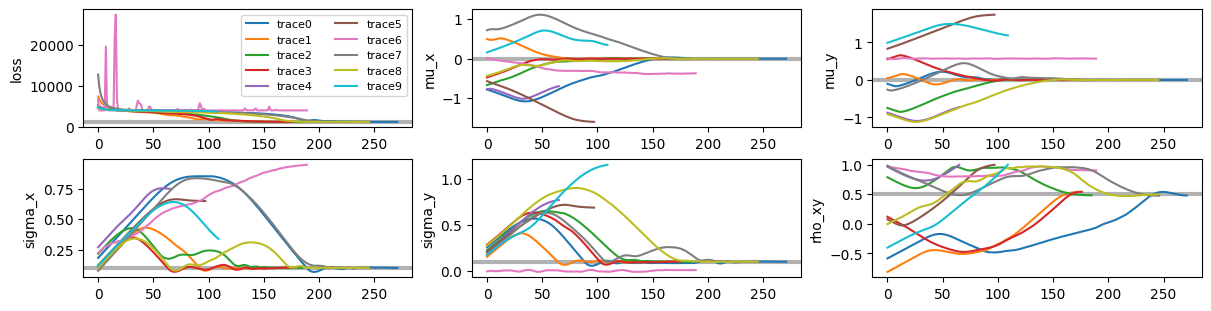

In [71]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,3),constrained_layout=True)
allax = np.ravel(axes)

# truths
allax[0].axhline(loss(true_params,noisy_obs),color='k',lw=3,alpha=0.3)
allax[0].set_ylabel('loss')
for i,label in enumerate(['mu_x','mu_y','sigma_x','sigma_y','rho_xy']):
    allax[i+1].axhline(true_params[i],color='k',lw=3,alpha=0.3)
    allax[i+1].set_ylabel(label)

# different adam traces 
for trace_num,(trace_loss, trace_params, trace_grad) in enumerate(adam_traces):
    allax[0].plot(trace_loss,label='trace%s'%trace_num)
    for i,label in enumerate(['mu_x','mu_y','sigma_x','sigma_y','rho_xy']):
        allax[i+1].plot(trace_params[:,i],label='trace%s'%trace_num)

allax[0].legend(loc='best',fontsize=8,ncol=2)

In [72]:
""" Fisher/Laplace Gaussian approximation of posterior at the endpoint found by adam (near truth in this case) """

### jax has a convenience function for the hessian of a function (this is equivalent to nested grad(grad(f) or jacobians) 
hess_loss = jax.hessian(loss)


fishers = [] 
for i in range(len(adam_traces)):
    
    ### evaluate hess at endpoint of adam
    hess_adam = hess_loss(adam_traces[i][1][-1],noisy_obs)

    ### if all eigvals are positive, this is a minimum (otherwise likely saddle point = hessian not invertible)
    if jnp.all(jnp.linalg.eigvalsh(hess_adam)>0) == True:
        fishers.append(jnp.linalg.inv(hess_adam))
    else:
        fishers.append(jnp.nan)



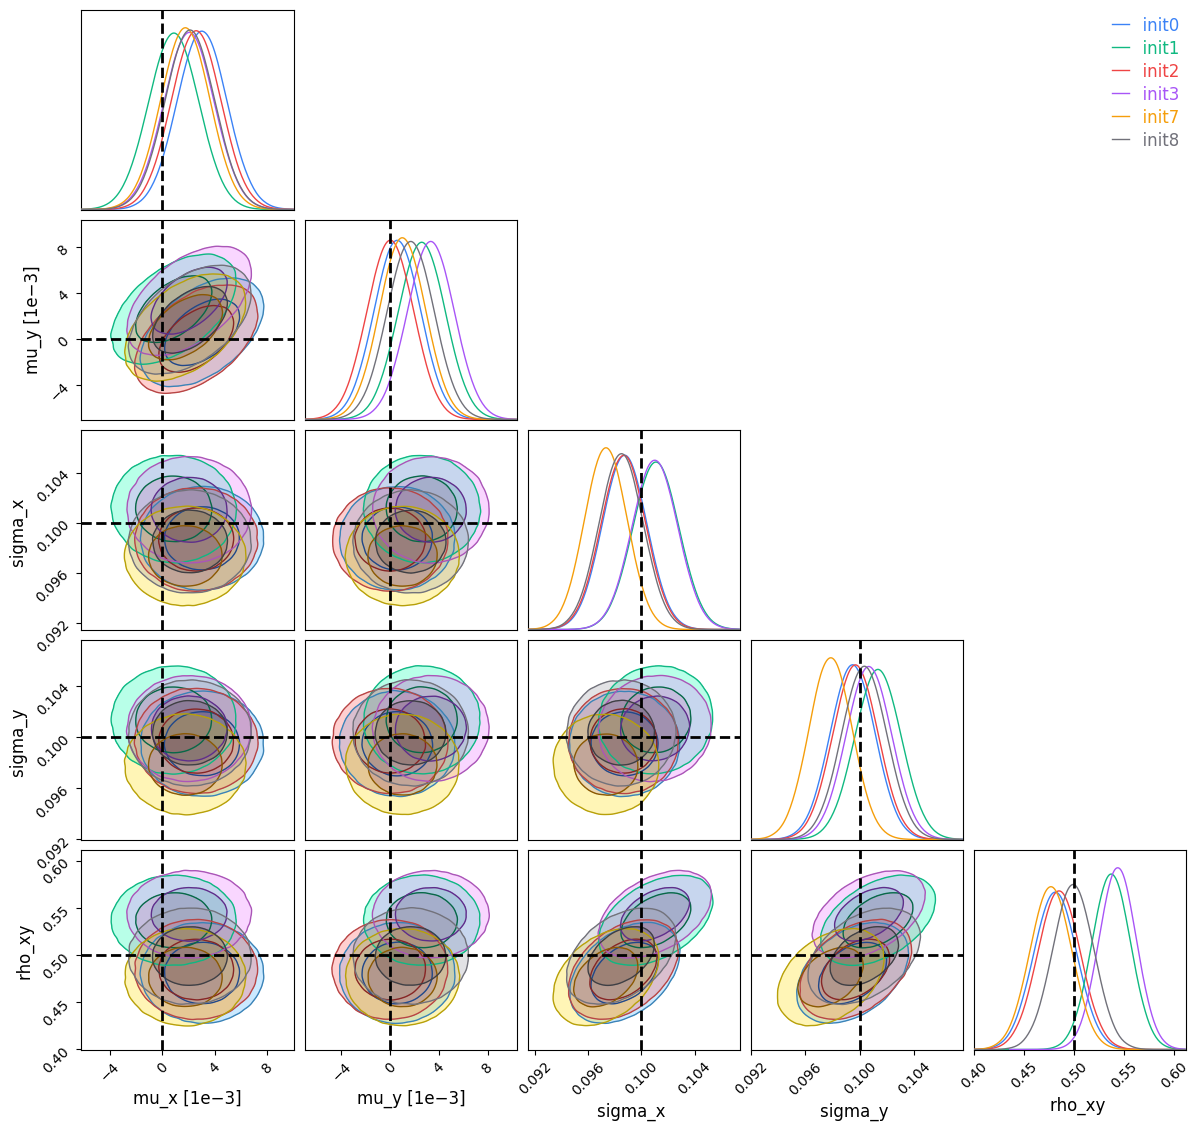

In [73]:
### simple corner plot

param_names = ['mu_x','mu_y','sigma_x','sigma_y','rho_xy']
true_params_dict = dict(zip(param_names, true_params))

c = ChainConsumer()
c.add_truth(Truth(location=true_params_dict,line_width=2))

for i in range(len(adam_traces)):
    if fishers[i] is not jnp.nan:
        fisher_adam = Chain.from_covariance(adam_traces[i][1][-1],fishers[i],
                                      columns=['mu_x','mu_y','sigma_x','sigma_y','rho_xy'],
                                      name='init%s'%i,shade_alpha=0.3,shade=True)
        c.add_chain(fisher_adam)

fig = c.plotter.plot()


# Hamiltonian Monte Carlo with numpyro

numpyro is a JAX-based probabilistic programming language that implements many gradient-based and gradient-free MCMC algorithms (including e.g., HMC/NUTS and a GPU-capable affine-invariant ensemble sampler aka emcee). Here we'll define a numpyro model and then just demonstrate HMC/NUTS. 

numpyro has a great collection of tutorials for different common problems: https://num.pyro.ai/en/0.18.0/tutorials/

WARNING: it turns out our implementation of the mvnormal inference problem neglects to account for symmetry (e.g., mu_x and mu_y are interchangeable) so our posterior here is multimodal. Would be worth thinking of reparameterizations or better priors or other constraints, comparing to nested sampling and/or training a normalizing flow to learn a global nonlinear transformation of the posterior to improve HMC sampling.

In [54]:
# start by defining our probabilistic numpyro model -- numpyro jits, etc. internally
def numpyro_model(obs_data=noisy_obs,obs_sigma=1.0):

    ### our stochastic random variables that we'll sample from the same uniform priors as above
    # NOTE: there are likely smarter ways to enforce symmetry to prevent multimodal posteriors
    mu_x = numpyro.sample('mu_x',dist.Uniform(llims[0],ulims[0]))
    mu_y = numpyro.sample('mu_y',dist.Uniform(llims[1],ulims[1]))
    # NOTE: numpyro offers better ways to sample from space of cov matrices directly (e.g., LKJ prior = deviation from identity matrix)
    sigma_x = numpyro.sample('sigma_x',dist.Uniform(llims[2],ulims[2]))
    sigma_y = numpyro.sample('sigma_y',dist.Uniform(llims[3],ulims[3]))    
    rho_xy = numpyro.sample('rho_xy',dist.Uniform(llims[4],ulims[4]))    

    # assemble mu_vector and cov_matrix for mvnormal just like above 

    # first package into mu vector and cov matrix 
    mu = jnp.array([mu_x,mu_y])
    cov = jnp.array([[sigma_x**2,rho_xy*sigma_x*sigma_y], 
                      [rho_xy*sigma_x*sigma_y,sigma_y**2]])

    # evaluate 2D gaussian image on our same universal xy grid
    pred_logpdf = jax_mvnormal.logpdf(xy_points, mean=mu, cov=cov).reshape(x_meshgrid.shape)
    pred_img = jnp.exp(pred_logpdf)
        
    # finally assume our 2D image is sampled from gaussian likelihood (all px independent) -- numpyro will sum logL internally 
    # here I'm assuming sigma=1.0 fixed, but we could fit for sigma (and/or let it vary per pixel) -- but keeping it simple for now
    obs = numpyro.sample('obs',dist.Normal(pred_img,obs_sigma), obs=obs_data)
    

In [55]:
### prior predictive checks -- test random draws of noisy 2D images from prior WITHOUT seeing the true noisy_obs

tstart = timer()
prior_predictive = Predictive(numpyro_model, num_samples=10)
prior_predictions = prior_predictive(key(0), obs_data=None, obs_sigma=1.0) 
print('finished in %.3f sec'%(timer()-tstart))

prior_obs = prior_predictions['obs']
prior_obs.shape

finished in 0.448 sec


(10, 50, 50)

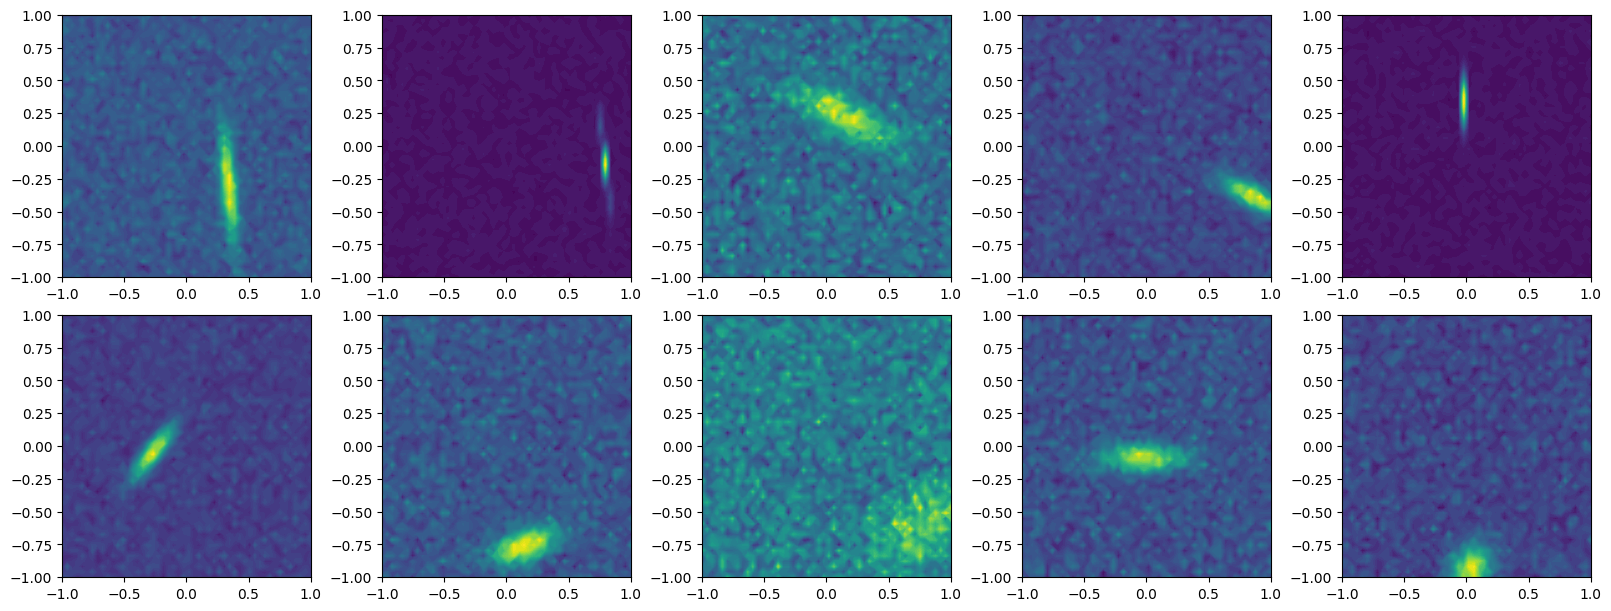

In [56]:
# plot those prior predictive checks to make sure our priors and model are fine, nothing crazy going on
fig, axes = plt.subplots(nrows=2,ncols=5,figsize=(16,6),constrained_layout=True)
allax = np.ravel(axes)

for i in range(prior_obs.shape[0]):
    allax[i].contourf(x_grid, y_grid, prior_obs[i], levels=50)

In [82]:
# initialize MCMC object -- we'll use NUTS which isa variant of HMC with automated adaptive stepsize tuning and stopping 

# can run more chains in parallel on GPU (or if you had more CPU cores)
mcmc = MCMC(NUTS(numpyro_model,dense_mass=True),num_warmup=1000,num_samples=1000,num_chains=4,
            # colab CPU version does not run chains in parallel (not enough cores?)
            # use 'vectorized' for single gpu, 'sequential' for colab 2 cpu cores, 'parallel' for multi-CPU/GPU
            chain_method='sequential') # could automate with try/except jax.devices('gpu') 

# run warmup first
# WARNING: try changing key or running many more chains -- some get stuck in bad local minima
# need reparameterization or stronger priors to leverage symmetry, avoid multimodal posterior
mcmc.warmup(key(0),obs_data=noisy_obs,obs_sigma=1.0,collect_warmup=True,
            extra_fields=('i','z','z_grad','potential_energy','energy','r','num_steps',
            'adapt_state.step_size','adapt_state.inverse_mass_matrix',))

warmup_samples = mcmc.get_samples(group_by_chain=True)    
warmup_extra_fields = mcmc.get_extra_fields(group_by_chain=True)


warmup: 100%|████████████| 1000/1000 [00:01<00:00, 872.76it/s, 3 steps of size 6.86e-01. acc. prob=0.79]


In [83]:
# now run actual sampling phase
mcmc.post_warmup_state = mcmc.last_state
mcmc.run(mcmc.post_warmup_state.rng_key,obs_data=noisy_obs,obs_sigma=1.0,
         extra_fields=('i','z','z_grad','potential_energy','energy','r','num_steps',
                      'adapt_state.step_size','adapt_state.inverse_mass_matrix',))    

samples = mcmc.get_samples(group_by_chain=True)  
samples_extra_fields = mcmc.get_extra_fields(group_by_chain=True)

mcmc.print_summary()

sample: 100%|███████████| 1000/1000 [00:00<00:00, 1748.37it/s, 7 steps of size 6.86e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.00      0.00      0.00     -0.00      0.01   5017.82      1.00
      mu_y      0.00      0.00      0.00     -0.00      0.00   4987.29      1.00
    rho_xy      0.49      0.02      0.49      0.46      0.53   4139.01      1.00
   sigma_x      0.10      0.00      0.10      0.10      0.10   4213.94      1.00
   sigma_y      0.10      0.00      0.10      0.10      0.10   3941.88      1.00

Number of divergences: 0


Parameter mu_y in chain Chain 2 is not constrained
Parameter sigma_x in chain Chain 0 is not constrained
Parameter rho_xy in chain Chain 3 is not constrained


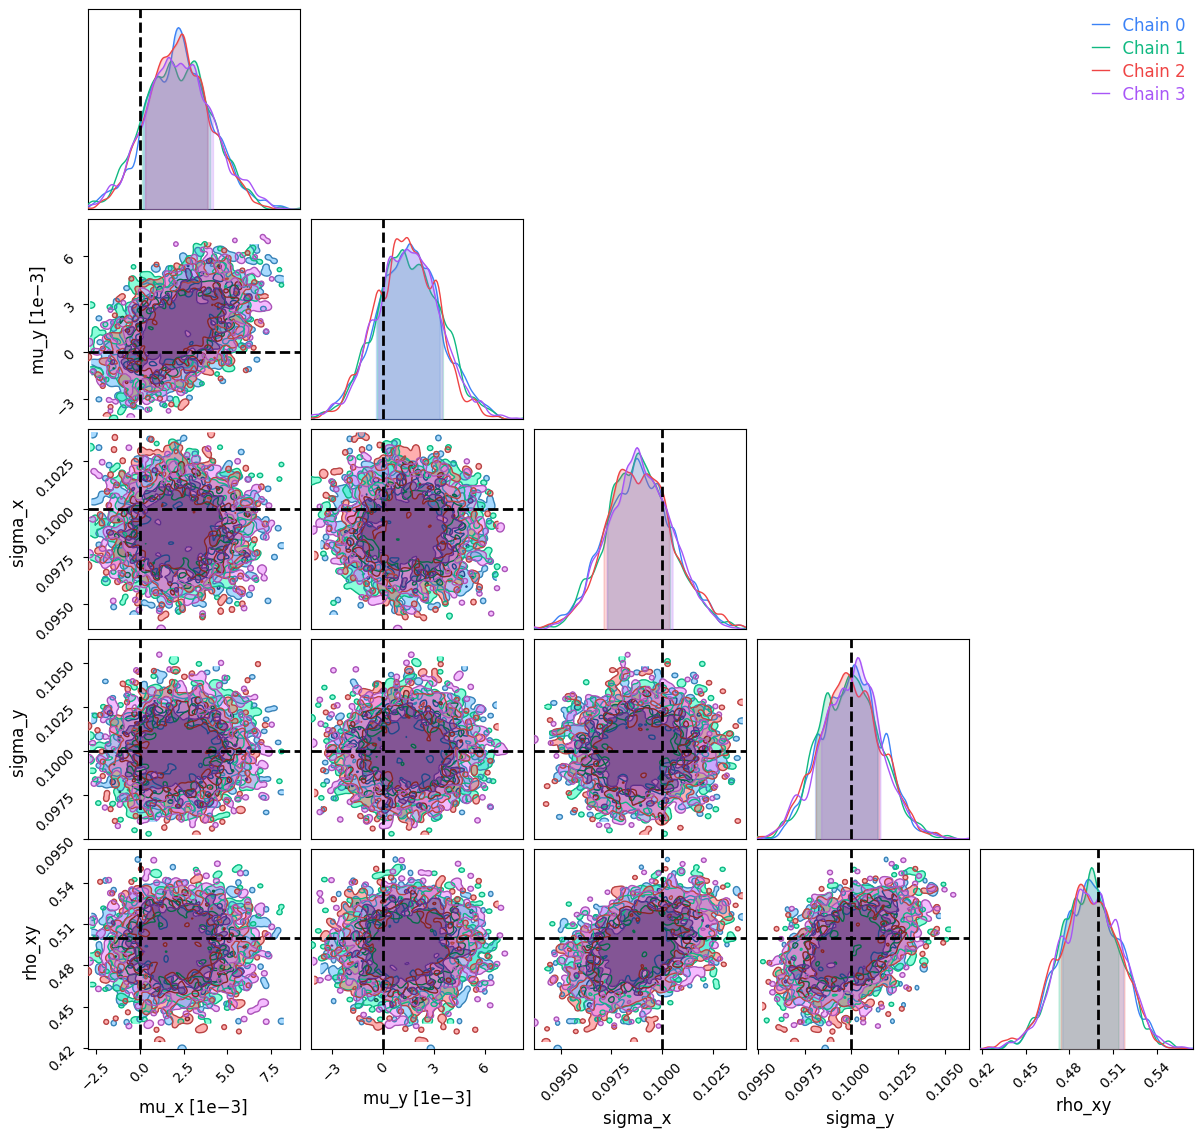

In [84]:
### ChainConsumer corner plot

# stack chains into a list of individual (n_samples, n_params) arrays
chains = []
for i in range(4): # iterate over chains
    chain_array = np.stack([samples[k][i] for k in param_names], axis=1)
    chains.append(chain_array)

# add each chain separately to chainconsumer
c = ChainConsumer()
for i, chain in enumerate(chains):
    c.add_chain(Chain(samples=pd.DataFrame(chain,columns=param_names), name=f"Chain {i}"))

c.add_truth(Truth(location=true_params_dict,line_width=2))

fig = c.plotter.plot()

In [85]:
# print log-posterior of final sample of each chain (useful for multimodality)
for i in range(4):
    print(i,numpyro.infer.util.log_density(numpyro_model,
                                           (noisy_obs,1.0),
                                           {},
                                           {k:samples[k][i,-1] for k in samples.keys()})[0])

0 -3528.648569091538
1 -3526.253080041126
2 -3526.2629156486005
3 -3526.6295252364803


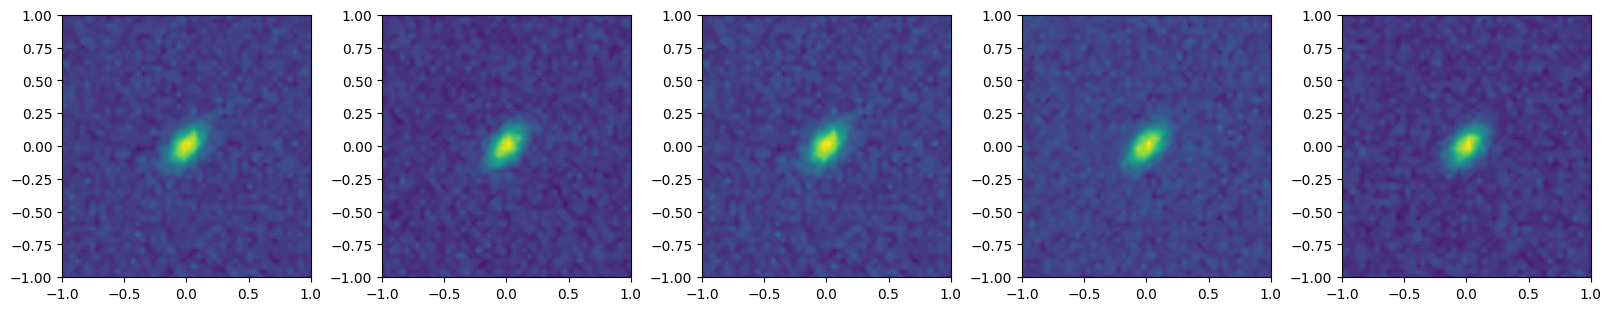

In [234]:
fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(16,3),constrained_layout=True)

axes[0].contourf(x_grid, y_grid, noisy_obs, levels=50)

for cnum in range(4):
    chain_params = jnp.array([samples[k][cnum,-1] for k in param_names])
    chain_obs = simulator(chain_params,key(cnum)) # should replace this with actual posterior predictive check from numpyro model, not my own noise
    axes[cnum+1].contourf(x_grid, y_grid, chain_obs, levels=50)

# emcee on GPUs with numpyro
## = many more walkers for efficient gradient-free affine-invariant ensembles sampling

numpyro also has a few gradient-free methods, notably affine invariant ensemble sampling (AIES aka emcee). These are designed to run on GPUs so you can have many more walkers for more efficient sampling. It's really easy to swap out our NUTS sampler with AIES instead, for our same numpyro model.

In [118]:
# initialize new mcmc object with AIES (emcee) kernel -- large # of chains/walkers is best
# on colab cannot really do this unless on GPU (CPU runtime only gives ~2 CPU cores)
emcee = MCMC(AIES(numpyro_model), num_warmup=1000, num_samples=2000, num_chains=100, chain_method='vectorized') 

# warmup first
emcee.warmup(key(0),obs_data=noisy_obs,obs_sigma=1.0,collect_warmup=True)
emcee_warmup_samples = emcee.get_samples(group_by_chain=True)

# actual sampling
emcee.post_warmup_state = emcee.last_state
emcee.run(emcee.post_warmup_state.rng_key,obs_data=noisy_obs,obs_sigma=1.0)    

emcee_samples = emcee.get_samples(group_by_chain=True)  

emcee.print_summary()

### probably seeing hints of multimodality from poor parameterization, not accounting for symmetry of problem

sample: 100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 299.90it/s, acc. prob=0.24]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mu_x      0.00      0.24      0.00     -0.27      0.14     65.62      2.41
      mu_y     -0.02      0.26      0.00     -0.08      0.58     62.40      2.46
    rho_xy      0.57      0.30      0.50      0.45      0.97     59.10      3.02
   sigma_x      0.13      0.08      0.10      0.04      0.30     54.83      4.38
   sigma_y      0.14      0.08      0.10      0.10      0.30     55.31      3.96



# Generate training data for SBI

Now we can use our sample_prior() and vmap_simulator() functions to generate a large training dataset. We want to keep track of (params, noisy_obs) pairs for this dataset and then train a NN to learn that mapping. 

In [86]:
# simulate many (params, noisy grid obs) pairs from prior + simulator:

# @partial(jax.jit,static_argnums=(0,1)) 
def generate_dataset(n_samples, base_key):
    # split base key into two subkeys -- one for prior and another for noisy obs
    key_prior, key_obs = jax.random.split(base_key)

    # first draw prior parameter samples
    params_samples = sample_prior(key_prior, n_samples)

    # we also need n_samples keys for the noisy obs generation
    noise_keys = jax.random.split(key_obs,n_samples)
    
    # finally simulate 2D noisy grid obs for each param set
    noisy_obs = vmap_simulator(params_samples, noise_keys)
    
    return params_samples, noisy_obs

test_tsg = generate_dataset(3,key(1))
test_tsg[0].shape, test_tsg[1].shape

((3, 5), (3, 50, 50))

In [87]:
# note: there is a way to speed up training set generation itself by parallelizing over multiple CPUs/GPUs, etc. 

tstart = timer()
params_train, obs_train = generate_dataset(10000,key(1))
print('finished in %.3f sec'%(timer()-tstart))

finished in 0.483 sec


In [88]:
# last minute -- decide to fit log_sigma instead to prevent the NN from predicting negative sigma (we can exp it afterwards)
params_train = params_train.at[:,2].set(jnp.log(params_train[:,2]))
params_train = params_train.at[:,3].set(jnp.log(params_train[:,3]))

# Define a NN that will learn mapping between params and noisy_obs

We will use the flax library to create a simple MLP with 2 hidden layers (64 neurons each) and one output layer (that predicts the 5 mvnormal for each batch obs). 

In [89]:
### define neural posterior density estimator -- we'll start with a simple MLP

# our class will inherit the base class flax.nn Module 
class PosteriorMLP(nn.Module):
    hidden_dim: int = 64

    # flax provides this decorator so we can just chain together a sequence of nn layers
    @nn.compact 
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1)) # 2D inputs must be flattened to 1D since flax MLP expects shape (batch_dim, feature_dim)
        x = nn.Dense(self.hidden_dim)(x) # from input (batch_dim,feature_dim) to (batch_dim, hidden_dim) so each batch/obs represented by NN hidden layer
        x = nn.relu(x) # relu activation applied to all batch_dim*hidden_dim elements
        x = nn.Dense(self.hidden_dim)(x) # second hidden layer from (batch_dim, hidden_dim) to again (batch_dim, hidden_dim) - flax handles different W, b
        x = nn.relu(x) # second relu 
        x = nn.Dense(5)(x)  # final output -- from NN (batch_dim, hidden_dim) to (batch_dim, 5) -- 5 predicted mvnormal parameters for each batch obs

        # May 27 -- enforce that rho predicted by NN is between [-1,1] -- if it is even slightly outside, covariance matrix will not be positive definite     
        # doesn't actually work...
        # x = x.at[:,4].set(jnp.tanh(x[:,4])) # applying tanh maps anything outside [-1,1] into that range (like sigmoid or any affine transform)
        
        return x

# Define loss and use gradient descent to train NN parameters

In [90]:
### first a simple loss function to compare params predicted by nn for each obs to the true params 
def loss_nn(nn_params, apply_fn, obs_batch, params_batch):

    # flax provides a function that converts nn params to predicted mvnormal parameters for each obs in batch_obs 
    pred_params = apply_fn(nn_params, obs_batch)

    # we'll use a very simple MSE loss
    # NOTE: in principle we should forward model the uncertainty too but i'll just assume sigma=1 as a placeholder for now
    loss = jnp.sum(0.5*((pred_params-params_batch)/1.0)**2) # this is like a gaussian log-likelihood [modulo the extra 2*
    
    return loss

### a wrapper for adam that takes input training data 
def train_nn_model(nn_model, params_train, obs_train, n_epochs=1000, lr=1e-3):
    rng = jax.random.key(42)

    # initialize nn params 
    nn_params = nn_model.init(rng, obs_train) 

    # initialize adam
    opt = optax.adam(lr)
    opt_state = opt.init(nn_params)

    # convenience adam step wrapper
    @jax.jit
    def step(nn_params, opt_state, obs_batch, params_batch): # here batch means current iteration value... 
        loss, grads = jax.value_and_grad(loss_nn)(nn_params, nn_model.apply, obs_batch, params_batch)
        updates, opt_state = opt.update(grads, opt_state)
        nn_params = optax.apply_updates(nn_params, updates)
        return nn_params, opt_state, loss

    # run for 1000 iterations
    # note: epoch has a specific meaning for ML in context of minibatching, so epoch != iteration except when doing full batch training (as here)
    for epoch in range(n_epochs):
        nn_params, opt_state, loss = step(nn_params, opt_state, obs_train, params_train)
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")
    
    return nn_params


In [98]:
# initialize flax MLP object
mlp_model = PosteriorMLP()

# run our training -- colab takes forever so i'll only do 200 iterations/epochs
# could probably speed this up and make training more robust with minibatching
tstart = timer()
trained_mlp_params = train_nn_model(mlp_model, params_train, obs_train, n_epochs=200,lr=1e-2)
print('finished training in %.3f sec'%(timer()-tstart))

Epoch 0: Loss = 328217.9309
Epoch 50: Loss = 6414.5655
Epoch 100: Loss = 3800.0600
Epoch 150: Loss = 2674.0615
finished training in 6.170 sec


In [99]:
# these is a dict of the trained nn parameters (weight matrix and bias vector per layer) 
# you could save this and read it in again later to redo inference on new obs 
trained_mlp_params 

{'params': {'Dense_0': {'bias': Array([-5.8082860e-02, -2.7617037e-02, -3.3684965e-02, -5.3822011e-02,
           4.2736955e-02,  1.7940409e-01, -7.8893349e-02, -5.7674911e-02,
          -6.2615901e-02, -3.9405689e-02,  3.9688144e-02, -4.7120366e-02,
          -6.1735615e-02, -6.9151662e-02, -1.9705598e-04, -3.1760767e-02,
          -6.4514711e-02, -1.6350962e-02, -5.2385062e-02, -5.0180562e-02,
          -5.5992857e-02, -6.2370241e-02, -3.2351106e-02, -5.4804888e-02,
          -4.2081356e-02, -4.7573086e-02, -6.0253758e-02,  3.2178469e-02,
          -6.1007529e-02, -6.1644655e-02, -3.8838848e-02, -2.1024564e-02,
          -6.3504286e-02,  2.9261576e-03, -5.3977523e-02, -6.1666176e-02,
          -6.3299529e-02, -6.6021711e-02, -4.6621352e-02, -5.5340964e-02,
           1.6762208e-02, -3.6542702e-02, -3.9347778e-03, -6.6348456e-02,
          -2.6596971e-02, -4.5238763e-02, -4.9305815e-02, -6.0480986e-02,
          -6.4069688e-02, -6.7897655e-02, -7.7705279e-02,  2.3935719e-01,
         

# Use the trained NN to do posterior predictive checks 

In [100]:
def posterior_predict(model, nn_params, obs, base_noise_key):
    
    # get predicted params from NN
    pred_params = model.apply(nn_params, obs) 

    pred_params = pred_params.at[:,2].set(jnp.exp(pred_params[:,2]))
    pred_params = pred_params.at[:,3].set(jnp.exp(pred_params[:,3]))

    # create noisy_obs for each NN-predicted parameter set
    noise_keys = jax.random.split(base_noise_key,obs.shape[0]) # first need to also generate noise keys
    pred_obs = vmap_simulator(pred_params, noise_keys)
    
    return pred_params, pred_obs


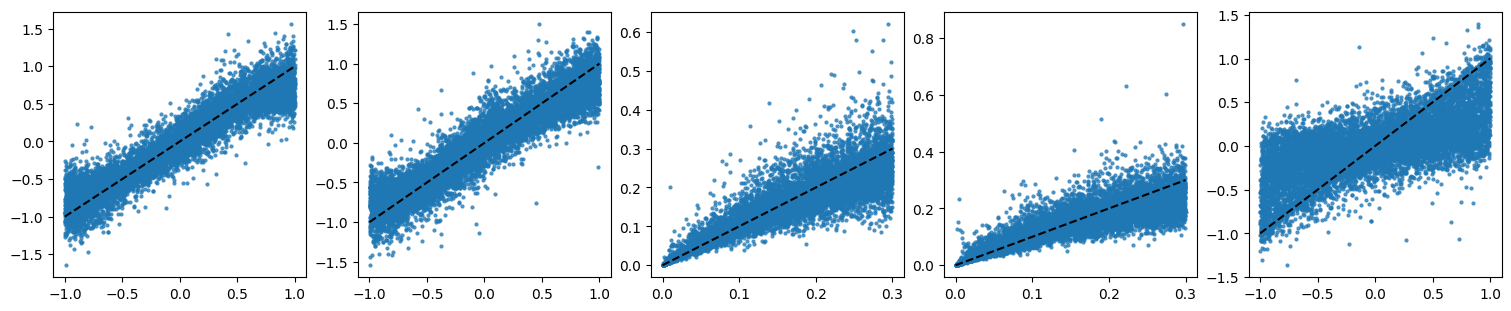

In [101]:
### first for the training itself: plot predicted vs true

pred_params, pred_obs = posterior_predict(mlp_model, trained_mlp_params, obs_train.reshape(obs_train.shape[0],-1), key(10)) # need to flatten test_obs 

fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(15,3),constrained_layout=True)

for i in range(5):
    if i in [2,3]:
        axes[i].plot(jnp.exp(params_train[:,i]),pred_params[:,i],'.',mec='none',alpha=0.8)
    else:
        axes[i].plot(params_train[:,i],pred_params[:,i],'.',mec='none',alpha=0.8)
    axes[i].plot(np.linspace(llims[i],ulims[i]),np.linspace(llims[i],ulims[i]),'k--')

    

[[ 0.62673891  0.09806156  0.19640672  0.06813659 -0.3413871 ]]
[0.  0.  0.1 0.1 0.5]


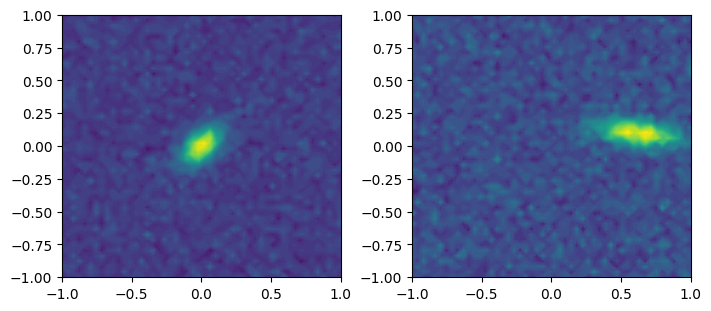

In [102]:
# first compare the prediction for our original true_params and its noisy_obs above
# we need to flatten and add batch dimension for our single true noisy_obs (since it is just a single 50x50 image, unlike our batched obs_train )
post_params0, post_obs0 = posterior_predict(mlp_model, trained_mlp_params, noisy_obs.reshape(1,-1), key(99))

# we're not crazy off given the large prior range
print(post_params0), 
print(true_params)

# plot true vs predicted noisy_obs
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(7,3),constrained_layout=True)
axes[0].contourf(x_grid, y_grid, noisy_obs, levels=50)
axes[1].contourf(x_grid, y_grid, post_obs0[0], levels=50)


In [103]:
### now let's generate new test data to assess the performance of the NN posterior estimator

test_params, test_obs = generate_dataset(100,key(5))
print(test_params.shape, test_obs.shape)

# get the params and 2D images predicted for each test pair
tstart = timer()
post_params, post_obs = posterior_predict(mlp_model, trained_mlp_params, test_obs.reshape(test_obs.shape[0],-1), key(10)) # need to flatten test_obs 2D images 
print('finished in %.3f sec'%(timer()-tstart))

post_params.shape, post_obs.shape

(100, 5) (100, 50, 50)
finished in 0.014 sec


((100, 5), (100, 50, 50))

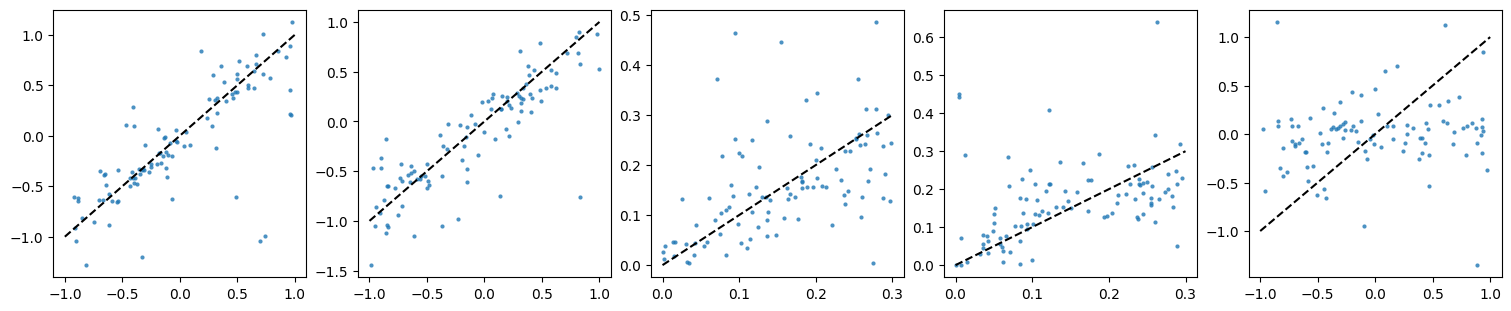

In [104]:
### let's plot predicted vs true for each of our 5 parameters for the test set

fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(15,3),constrained_layout=True)

for i in range(5):
    axes[i].plot(test_params[:,i],post_params[:,i],'.',mec='none',alpha=0.8)
    axes[i].plot(np.linspace(llims[i],ulims[i]),np.linspace(llims[i],ulims[i]),'k--')

[-0.64244666  0.68564642  0.15582802  0.10432395 -0.10724414]
[-0.53782101  0.81471645  0.12163603  0.07797233 -0.01225501]


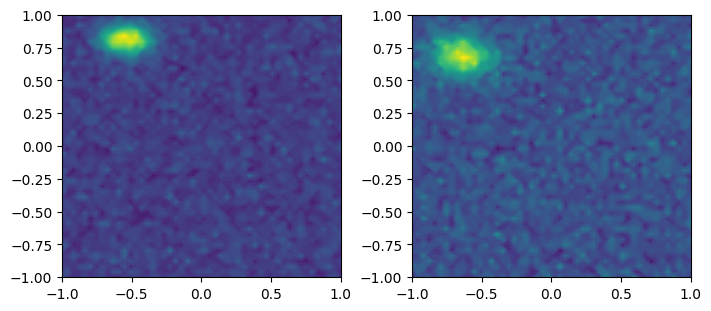

In [105]:
# plot a random check
ind = 6
print(post_params[ind])
print(test_params[ind])

ind_obs = simulator(post_params[ind],key(1))

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(7,3),constrained_layout=True)
axes[0].contourf(x_grid, y_grid, test_obs[ind], levels=50)
axes[1].contourf(x_grid, y_grid, ind_obs, levels=50)


In [106]:
### let's inspect a few of the catastrophic failures 

# immediate bad ones are where rho is not between [-1,1] -- that would lead to non-positive-definite cov matrix = NaN mvnormal logpdf
ind_bad = np.where((post_params[:,4]<-1) | (post_params[:,4]>1))[0]
ind_bad

array([21, 67, 96])

In [107]:
post_obs[ind_bad[0]]

Array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float64)

# Switch to a CNN with flax 

### Warning: more expensive to train, doesn't work yet, need better architecture and more training data?

If we were satisfied, then at this point we would save our trained_nn_params so we can re-read and do posterior inference with new obs later. 

However clearly the above test/validation shows that this MLP didn't do particularly well. There are ways we could get it to work better by changing the MLP architecture, train for longer w/ a bigger dataset -- but in this case it is useful to switch to a completely differently NN architecture, namely a CNN. Notice how for the MLP, we had to flatten the input Gaussians into 1D arrays since the MLP accepts input batched obs of shape (batch_dim, feature_dim). But flattening a 2D image throws out so much information about the location/orientation/ellipticity of the 2D Gaussian! It's remarkable how well the MLP did anyway but CNNs are another NN architecture well suited for images. flax makes it easy to swap out nn.Dense with nn.Conv instead.

WARNING: This doesn't work yet but you get the idea... 

In [245]:
class PosteriorCNN(nn.Module):
    
    @nn.compact
    def __call__(self, x):  # x: (batch_dim, img_height_px, img_width_px)
        
        x = x[..., None]  # add extra channel dimension for CNN: (batch_dim, height_dim, width_dim, 1) 
        x = nn.Conv(features=16, kernel_size=(3,3))(x) # learn large-scale features first
        x = nn.relu(x)
        x = nn.Conv(features=32, kernel_size=(3,3))(x) # learn higher-res features
        x = nn.relu(x)
        
        x = x.reshape((x.shape[0], -1))  # flatten for dense layers
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(32)(x)
        x = nn.relu(x)
        x = nn.Dense(5)(x) # final predicted mvnormal parameters
        
        return x

In [249]:
# initialize flax MLP object
cnn_model = PosteriorCNN()

In [250]:
# CNN expensive to train, run for less and use only ~1K training data
# proper way to do this is minibatch gradient descent: split data into N minibatches, do N adam steps (1 per minibatch) = 1 epoch, shuffle/resplit, repeat

tstart = timer()
trained_cnn_params = train_nn_model(cnn_model, params_train, obs_train, n_epochs=200,lr=1e-2) 
print('finished training in %.3f sec'%(timer()-tstart))

Epoch 0: Loss = 9441.9827
Epoch 50: Loss = 3958.7871
Epoch 100: Loss = 1373.9476
Epoch 150: Loss = 1268.7519
finished training in 892.659 sec


[[-0.01534716 -0.00641409  0.0885106   0.09625564 -0.02333343]]
[0.  0.  0.1 0.1 0.5]


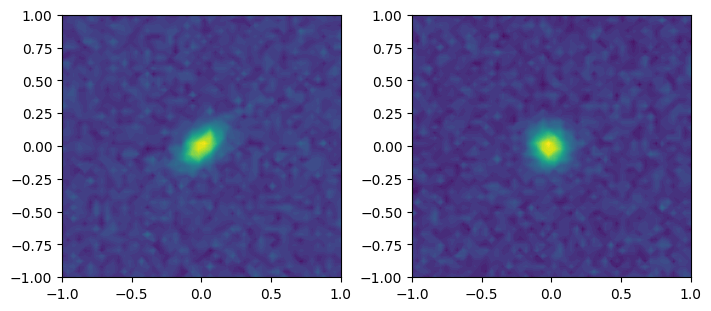

In [262]:
# just as before, get posterior predictive check
cnn_params0, cnn_obs0 = posterior_predict(cnn_model, trained_cnn_params, noisy_obs[None,...], key(99)) # add leading batch leading to single true noisy_obs

# we're not crazy off given the large prior range
print(cnn_params0)
print(true_params)

# plot true vs predicted noisy_obs
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(7,3),constrained_layout=True)
axes[0].contourf(x_grid, y_grid, noisy_obs, levels=50)
axes[1].contourf(x_grid, y_grid, cnn_obs0[0], levels=50)


In [263]:
### now let's generate new test data to assess the performance of the NN posterior estimator

# get the params and 2D images predicted for each test pair
tstart = timer()
cnn_params, cnn_obs = posterior_predict(cnn_model, trained_cnn_params, test_obs, key(10)) # dont need to flatten for CNN
print('finished in %.3f sec'%(timer()-tstart))

cnn_params.shape, cnn_obs.shape

finished in 0.437 sec


((100, 5), (100, 50, 50))

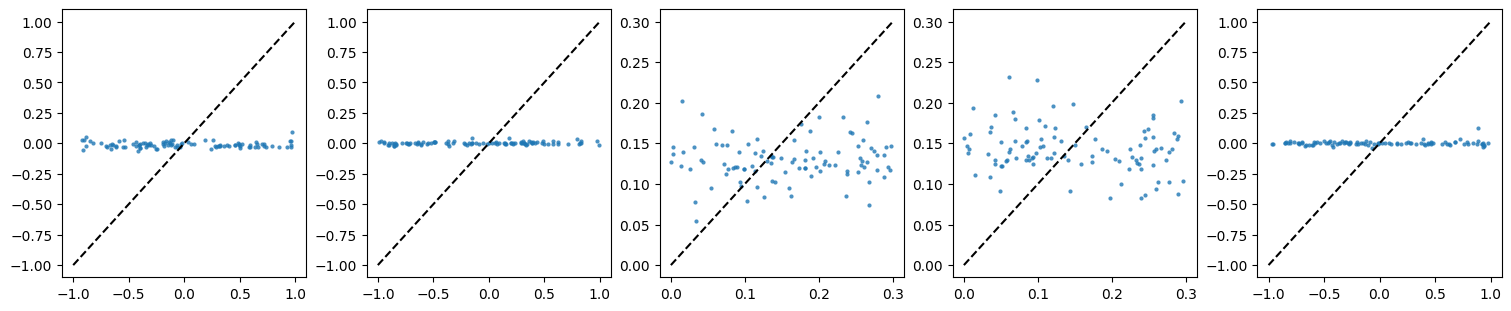

In [264]:
### let's plot predicted vs true for each of our 5 parameters for the test set

fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(15,3),constrained_layout=True)

for i in range(5):
    axes[i].plot(test_params[:,i],cnn_params[:,i],'.',mec='none',alpha=0.8)
    axes[i].plot(np.linspace(llims[i],ulims[i]),np.linspace(llims[i],ulims[i]),'k--')

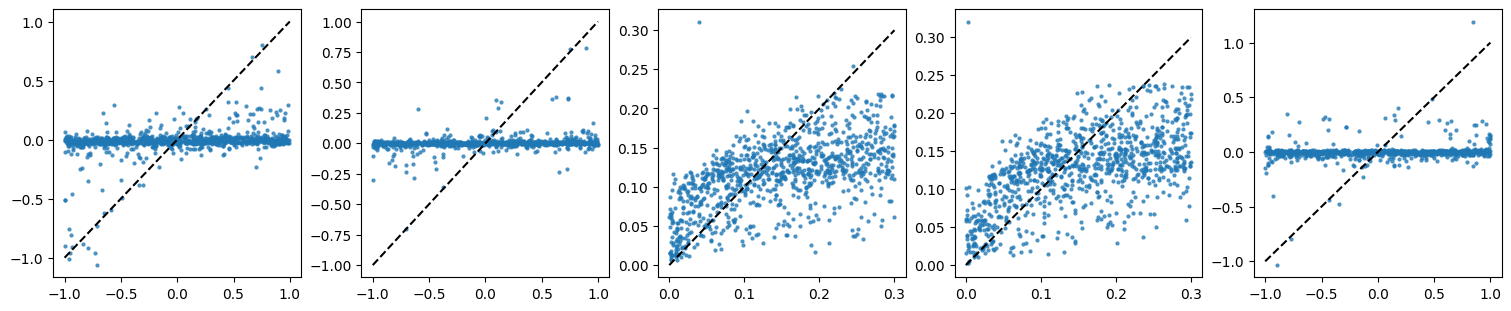

In [268]:
cnn_paramst, cnn_obst = posterior_predict(cnn_model, trained_cnn_params, obs_train, key(10)) # need to flatten test_obs 2D images 

fig, axes = plt.subplots(nrows=1,ncols=5,figsize=(15,3),constrained_layout=True)

for i in range(5):
    if i in [2,3]:
        axes[i].plot(jnp.exp(params_train[:,i]),cnn_paramst[:,i],'.',mec='none',alpha=0.8)
    else:
        axes[i].plot(params_train[:,i],cnn_paramst[:,i],'.',mec='none',alpha=0.8)
    axes[i].plot(np.linspace(llims[i],ulims[i]),np.linspace(llims[i],ulims[i]),'k--')

# Things to try next

- try better priors and/or reparameterize model to leverage symmetry and prevent multimodal posterior (e.g., mu_x, mu_y interchangeable)
- improve the MLP and CNN architectures, perhaps add more transformations / loss penalties, train for longer on larger training data
- forward model uncertainties on mvnormal parameters -- not just point estimates but also sigma's or full cov matrix 
- try Will Handley's new jax nested sampling routine in blackjax and/or port over other NN architectures from Matt Ho's ltu-ili
- use normalizing flows to learn the posterior and derive nonlinear global transformation to improve HMC sampling
- try equinox instead of flax for defining NN model class
- adapt for other simple models (e.g., spectroscopic/photometric modeling, dynamical diffeq-based models)

I'd love to hack on extensions of this or other simple examples -- email me vgp2108@columbia.edu !